### Model Catalog: train the model

* dataset: Breast Cancer Dataset
* model: LightGBM

The goal here is not to develop the best model. We will use some reasonable techniques to get a good model and then we will save it to the model catalog

In [1]:
import pandas as pd
import numpy as np

from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import lightgbm as lgb

In [2]:
### load the data from sklearn
data = load_breast_cancer(as_frame=True)

# as Pandas DataFRame
orig_df = data.frame

orig_df.shape

(569, 31)

In [3]:
# target column
orig_df['target'].unique()

array([0, 1])

In [4]:
# static train/validation split
TRAIN_FRAC = 0.8
NUM_TRAIN = int(TRAIN_FRAC*orig_df.shape[0])

# shuffle
orig_df = orig_df.sample(frac = 1.)

train_df = orig_df[0:NUM_TRAIN]
valid_df = orig_df[NUM_TRAIN:]

print('Num training samples:', train_df.shape[0])
print('Num validation samples:', valid_df.shape[0])

Num training samples: 455
Num validation samples: 114


In [5]:
train_df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
346,12.06,18.90,76.66,445.3,0.08386,0.05794,0.00751,0.008488,0.1555,0.06048,...,27.06,86.54,562.6,0.12890,0.13520,0.04506,0.05093,0.2880,0.08083,1
85,18.46,18.52,121.10,1075.0,0.09874,0.10530,0.13350,0.087950,0.2132,0.06022,...,27.68,152.20,1603.0,0.13980,0.20890,0.31570,0.16420,0.3695,0.08579,0
561,11.20,29.37,70.67,386.0,0.07449,0.03558,0.00000,0.000000,0.1060,0.05502,...,38.30,75.19,439.6,0.09267,0.05494,0.00000,0.00000,0.1566,0.05905,1
331,12.98,19.35,84.52,514.0,0.09579,0.11250,0.07107,0.029500,0.1761,0.06540,...,21.95,99.21,634.3,0.12880,0.32530,0.34390,0.09858,0.3596,0.09166,1
274,17.93,24.48,115.20,998.9,0.08855,0.07027,0.05699,0.047440,0.1538,0.05510,...,34.69,135.10,1320.0,0.13150,0.18060,0.20800,0.11360,0.2504,0.07948,0


In [6]:
# names
features = [x for x in train_df.columns if x != 'target']

TARGET = 'target'

In [7]:
x_train = train_df[features].values
x_valid = valid_df[features].values

y_train = train_df[TARGET].values
y_valid = valid_df[TARGET].values

In [8]:
# Apply standard scaler: a good enough preprocessing step
sc = StandardScaler()

x_train_scaled = sc.fit_transform(x_train)
x_valid_scaled = sc.transform(x_valid)

### data is ready for training. We will use LightGBM
* all features are continuous

In [9]:
%%time

params = {
   "learning_rate": 0.05
}

model = lgb.LGBMClassifier(objective='binary', seed=4321, n_jobs=-1, n_estimators=100, num_leaves = 30, max_depth=15, early_stopping_rounds=20, 
                          learning_rate = 0.05)

best_model = model.fit(x_train_scaled, y_train, eval_set=[(x_valid_scaled, y_valid)], verbose=1, feature_name=features, eval_metric = 'auc')

/home/datascience/conda/mlcpuv1/lib/python3.6/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's auc: 0.969404	valid_0's binary_logloss: 0.632901
Training until validation scores don't improve for 20 rounds
[2]	valid_0's auc: 0.976329	valid_0's binary_logloss: 0.597626
[3]	valid_0's auc: 0.976973	valid_0's binary_logloss: 0.566289
[4]	valid_0's auc: 0.978422	valid_0's binary_logloss: 0.537107
[5]	valid_0's auc: 0.980515	valid_0's binary_logloss: 0.510396
[6]	valid_0's auc: 0.981965	valid_0's binary_logloss: 0.486659
[7]	valid_0's auc: 0.982931	valid_0's binary_logloss: 0.464237
[8]	valid_0's auc: 0.982287	valid_0's binary_logloss: 0.443871
[9]	valid_0's auc: 0.983253	valid_0's binary_logloss: 0.424946
[10]	valid_0's auc: 0.982448	valid_0's binary_logloss: 0.407319
[11]	valid_0's auc: 0.983897	valid_0's binary_logloss: 0.390288
[12]	valid_0's auc: 0.983897	valid_0's binary_logloss: 0.375774
[13]	valid_0's auc: 0.985024	valid_0's binary_logloss: 0.361987
[14]	valid_0's auc: 0.985024	valid_0's binary_logloss: 0.349325
[15]	valid_0's auc: 0.984702	valid_0's binary_loglos

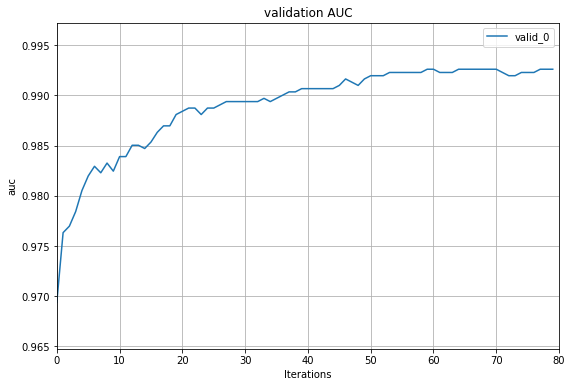

In [10]:
lgb.plot_metric(model, metric='auc', figsize=(9, 6), title='validation AUC');

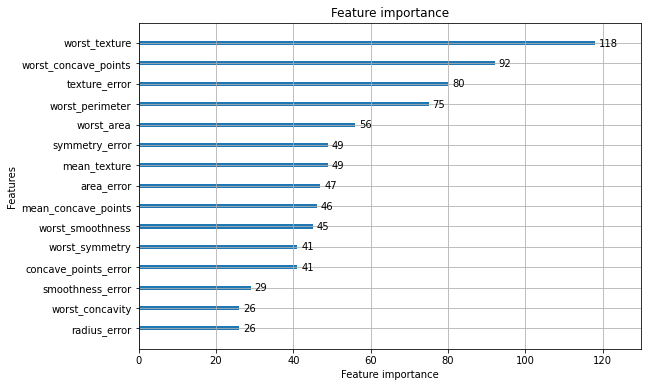

In [11]:
lgb.plot_importance(model, figsize=(9, 6), max_num_features=15);

In [12]:
y_pred = best_model.predict_proba(x_valid_scaled)

y_pred = y_pred[:, 1]

In [13]:
y_pred_labels = best_model.predict(x_valid_scaled)

In [14]:
cm = confusion_matrix(y_valid, y_pred_labels)

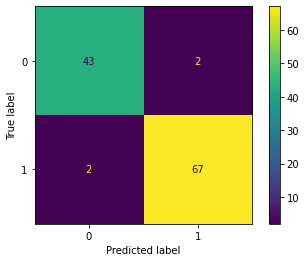

In [15]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

disp.plot();

### As you can see the model is enough accurate

In [ ]:
### Prepare to save the model to Model Catalog

In [16]:
from ads.common.model_artifact import ModelArtifact
from ads.common.model_export_util import prepare_generic_model
from ads import set_auth
import os

import json
import pickle

In [17]:
# env and auth
compartment_id = os.environ['NB_SESSION_COMPARTMENT_OCID']
project_id = os.environ['PROJECT_OCID']

set_auth(auth='resource_principal')

In [18]:
# 1. prepare artifacts directory

PATH_ARTEFACT = f"./model-files"

if not os.path.exists(PATH_ARTEFACT):
    os.mkdir(PATH_ARTEFACT)

In [20]:
# 2. Serialize model and scaler
pickle.dump(best_model, open(PATH_ARTEFACT + '/model.pkl', 'wb'))
      
# in addition, for data preprocessing, I need to save the Scaler
pickle.dump(sc, open(PATH_ARTEFACT + '/scaler.pkl', 'wb'))

In [21]:
# 3. prepare deploy to Model Catalog
artifact = prepare_generic_model(PATH_ARTEFACT, function_artifacts=False, force_overwrite=True, data_science_env=True)

INFO:ADS:We give you the option to specify a different inference conda environment for model deployment purposes. By default it is assumed to be the same as the conda environment used to train the model. If you wish to specify a different environment for inference purposes, please assign the path of a published or data science conda environment to the optional parameter `inference_conda_env`. 


In [82]:
%%writefile {PATH_ARTEFACT}/score.py

import io
import pandas as pd
import numpy as np
import json
import os
import pickle
import logging 

model_name = 'model.pkl'
scaler_name = 'scaler.pkl'

"""
   Inference script. This script is used for prediction by scoring server when schema is known.
"""

model = None
scaler = None

logging.basicConfig(format='%(name)s - %(levelname)s - %(message)s', level=logging.INFO)
logger_pred = logging.getLogger('model-prediction')
logger_pred.setLevel(logging.INFO)
logger_feat = logging.getLogger('features')
logger_feat.setLevel(logging.INFO)

def load_model():
    """
    Loads model from the serialized format

    Returns
    -------
    model:  a model instance on which predict API can be invoked
    """
    global model, scaler
    
    model_dir = os.path.dirname(os.path.realpath(__file__))
    contents = os.listdir(model_dir)
    
    if model_name in contents:
        with open(os.path.join(os.path.dirname(os.path.realpath(__file__)), model_name), "rb") as file:
            with open(os.path.join(os.path.dirname(os.path.realpath(__file__)), scaler_name), "rb") as sfile:
                model = pickle.load(file)
                scaler = pickle.load(sfile)
                
                assert model != None
                assert scaler != None
                
                logger_pred.info("Loaded model and scaler...")
    else:
        raise Exception('{0} is not found in model directory {1}'.format(model_name, model_dir))
    
    return model

# added for data scaling
def preprocess_data(x):
    
    global scaler
    
    logger_pred.info("Scaling features...")
    
    x = scaler.transform(x)
    
    return x

def predict(data, model=load_model()):
    """
    Returns prediction given the model and data to predict

    Parameters
    ----------
    model: Model instance returned by load_model API
    data: Data format as expected by the predict API of the core estimator. For eg. in case of sckit models it could be numpy array/List of list/Panda DataFrame

    Returns
    -------
    predictions: Output from scoring server
        Format: {'prediction':output from model.predict method}

    """
    
    logger_pred.info("In predict...")
    
    # some check
    assert model is not None, "Model is not loaded"
    
    x = pd.read_json(io.StringIO(data)).values
    
    logger_feat.info("Logging features before scaling")
    logger_feat.info(x)
    logger_feat.info("...")
    
    # apply scaling
    x = preprocess_data(x)
    
    logger_feat.info("Logging features after scaling")
    logger_feat.info(x)
    logger_feat.info("...")
    
    logger_pred.info("Invoking model......")
    
    preds = model.predict_proba(x)
    
    preds = np.round(preds[:, 1], 4)
    preds = preds.tolist()
    
    logger_pred.info("Logging predictions")
    logger_pred.info(preds)
    
    return { 'prediction': preds }

Overwriting ./model-files/score.py


### tests before saving to model catalog

In [83]:
%load_ext autoreload

%autoreload 2

# add the path of score.py: 

import sys 
sys.path.insert(0, PATH_ARTEFACT)

from score import load_model, predict

# Load the model to memory 
_ = load_model()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
INFO:model-prediction:Loaded model and scaler...


In [84]:
# scaling will be done by the service...
x_input = x_valid[0:2]

In [85]:
predictions_test = predict(json.dumps(x_input.tolist()), _)

INFO:model-prediction:In predict...
INFO:features:Logging features before scaling
INFO:features:[[1.364e+01 1.560e+01 8.738e+01 5.753e+02 9.423e-02 6.630e-02 4.705e-02
  3.731e-02 1.717e-01 5.660e-02 3.242e-01 6.612e-01 1.996e+00 2.719e+01
  6.470e-03 1.248e-02 1.810e-02 1.103e-02 1.898e-02 1.794e-03 1.485e+01
  1.905e+01 9.411e+01 6.834e+02 1.278e-01 1.291e-01 1.533e-01 9.222e-02
  2.530e-01 6.510e-02]
 [1.953e+01 3.247e+01 1.280e+02 1.223e+03 8.420e-02 1.130e-01 1.145e-01
  6.637e-02 1.428e-01 5.313e-02 7.392e-01 1.321e+00 4.722e+00 1.099e+02
  5.539e-03 2.644e-02 2.664e-02 1.078e-02 1.332e-02 2.256e-03 2.790e+01
  4.541e+01 1.802e+02 2.477e+03 1.408e-01 4.097e-01 3.995e-01 1.625e-01
  2.713e-01 7.568e-02]]
INFO:features:...
INFO:model-prediction:Scaling features...
INFO:features:Logging features after scaling
INFO:features:[[-0.1238277  -0.84942669 -0.17235378 -0.21278503 -0.14604114 -0.72370159
  -0.51078994 -0.28109155 -0.3504825  -0.90178206 -0.28312334 -0.9992251
  -0.41419185 -

In [86]:
# Saving the model artifact to the model catalog.
catalog_entry = artifact.save(display_name='model-ws-bc', 
              description='A model for Breast Cancer Dataset')

ERROR:ads:ADS Exception
Traceback (most recent call last):
  File "/home/datascience/conda/mlcpuv1/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3343, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-86-ee2241adca52>", line 3, in <module>
    description='A model for Breast Cancer Dataset')
  File "/home/datascience/conda/mlcpuv1/lib/python3.6/site-packages/ads/common/model_artifact.py", line 385, in save
    training_code_info = self._training_code_info(ns, training_script_path, ignore_pending_changes)
  File "/home/datascience/conda/mlcpuv1/lib/python3.6/site-packages/ads/common/model_artifact.py", line 434, in _training_code_info
    self._assert_path_not_dirty(self.artifact_dir, repo, ignore_pending_changes)
  File "/home/datascience/conda/mlcpuv1/lib/python3.6/site-packages/ads/common/model_artifact.py", line 448, in _assert_path_not_dirty
    raise ChangesNotCommitted(path_abs)
ads.common.model_artifact.ChangesNotCommi

ChangesNotCommitted: 
            File(s) at /home/datascience/model-catalogv2/model-files are either dirty or untracked. 
            Please commit changes and then save the model, or set `ignore_pending_changes=True`.
        